# Factorización de matrices para filtrado colaborativo
Autor: [Jorge Esteban Mendoza Ortiz (418002863)](mailto:esteban.mendoza@ciencias.unam.mx) - Facultad de Ciencias. UNAM.

El marco teórico que sustenta el método utilizado en este _notebook_ se puede encontrar en [este documento]().

## Cargar datos

In [1]:
import pandas as pd
import numpy as np

Primero cargamos la tabla de _ratings_ de la base de datos `ml-latest-small` de [MovieLens](http://movielens.org), que contiene 100,836 _ratings_ de 9,742 películas. Estos datos fueron creados por 610 usuarios entre el 29 de marzo de 1996 y el 24 de septiembre del 2018.

In [2]:
ratings = pd.read_csv("https://github.com/esteban-mendoza/svd-recommender/raw/master/ml-latest-small/ratings.csv")
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Reordenamos los datos para obtener un _DataFrame_ en cuyas filas se encuentran los _id_ de usuario y en cuyas columnas están los _id_ de cada película. La entrada $(i,j)$ del _DataFrame_ tiene un número, que es la calificación dada por el usuario $i$ a la película $j$, y si el usuario en cuestión no calificó la película, hay un `NaN`.

In [3]:
users_items = ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

In [4]:
users_items.shape

(610, 9724)

In [5]:
users_items

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Datos de validación

In [6]:
from numpy.random import default_rng

Para separar los datos de validación, primero instanciamos un generador aleatorio en la semilla `1001` para que el código sea reproducible.

In [7]:
rng = default_rng(seed=1001)

Designamos por `p` a la razón de entradas del _DataFrame_ que separaremos para validar nuestro predictor.

In [8]:
p = 0.2

En este paso calculamos el número de columnas y de filas que necesitamos para obtener el 20% de las entradas.

In [9]:
m_validation_users = int(np.sqrt(p) * users_items.shape[0])
n_validation_items = int(np.sqrt(p) * users_items.shape[1])

Posteriormente, extraemos aleatoriamente `m_validation_users` _ids_ de usuarios y `n_validation_items` _ids_ de películas sin reemplazo.

In [10]:
users_validation_index = rng.choice(users_items.index, m_validation_users, replace=False)
items_validation_index = rng.choice(users_items.columns, n_validation_items, replace=False)

Habiendo obtenido las entradas aleatorias deseadas, guardamos el subconjunto de entradas de validación en `users_items_validation`.

In [ ]:
users_items_validation = users_items.reindex(index=users_validation_index, columns=items_validation_index)
users_items_validation

Podemos verificar que el número de entradas del subconjunto de datos de validación es aproximadamente el 20%.

In [ ]:
users_items_validation.size / users_items.size

A continuación, determinamos el subconjunto de datos de entrenamiento poniendo valores `NaN` en las entradas del subconjunto de validación.

In [ ]:
users_items_training = users_items.copy()

In [ ]:
users_items_training.loc[users_validation_index, items_validation_index] = np.nan

## Preprocesamiento

Calculamos el número de entradas _vacías_ para tener una medida de cuán dispersa es la matriz de usuarios y películas.

In [ ]:
users_items_training.isna().values.sum() / users_items.size

Ahora calculamos el _ranking_ medio de cada usuario y utilizamos esta información para centrar los _rankings_ alrededor de 0.

In [ ]:
avg_ratings = users_items_training.mean(axis=1)
avg_ratings.head()

In [ ]:
users_items_normalized = users_items_training.sub(avg_ratings, axis=0)

Ahora que los _rankings_ están centrados alrededor de 0, imputamos las casillas vacías con el valor 0, que podemos interpretar como una calificación neutral.

In [18]:
users_items_normalized = users_items_normalized.fillna(0)

In [19]:
users_items_normalized

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,0.000000,-0.366379,0.0,0.0,-0.366379,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.363636,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,-1.157399,0.000000,0.000000,0.0,0.0,0.000000,-1.157399,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.213904,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,-0.634176,-1.134176,-1.134176,0.0,0.0,0.000000,0.000000,0.0,0.0,0.865824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Entrenamiento de modelo

In [20]:
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

Calculamos ahora la descomposición de valores singulares (SVD, por sus siglas en inglés) de la matriz de usuarios y películas normalizado (centrado alrededor del 0) manteniendo únicamente los primeros 60 valores principales, que graficamos después.

In [21]:
U, S, Vt = svds(users_items_normalized, k=60)

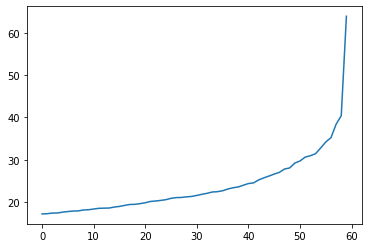

In [22]:
plt.plot(S)

Habiendo reducido la dimensionalidad del espacio de datos, reconstruimos la matriz de usuarios y películas multiplicando los factores obtenidos por medio de SVD: $$R = U\Sigma V^T$$

Esta matriz es densa. Posteriormente, sumamos nuevamente las medias por usuario que calculamos antes para que las predicciones sean comparables con los datos originales.

In [23]:
users_items_prediction = np.dot(np.dot(U, np.diag(S)), Vt)
users_items_prediction = users_items_prediction + avg_ratings.values.reshape(-1,1)

Creamos un _DataFrame_ con los nombres correctos de filas y columnas con las predicciones obtenidas.

In [24]:
users_items_prediction = pd.DataFrame(
    users_items_prediction,
    index=users_items_normalized.index,
    columns=users_items_normalized.columns
)
users_items_prediction

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.066767,4.265097,4.362582,4.395009,4.387957,4.214700,4.266066,4.295709,4.379188,4.387427,...,4.367536,4.370355,4.364717,4.364717,4.367536,4.364717,4.367536,4.367536,4.367536,4.366379
2,3.929467,3.941839,3.933641,3.951655,3.964911,3.929173,3.924842,3.951263,3.954133,3.971659,...,3.948172,3.947918,3.948425,3.948425,3.948172,3.948425,3.948172,3.948172,3.948172,3.948276
3,2.528777,2.537182,2.432912,2.428614,2.436633,2.288249,2.503261,2.512311,2.447366,2.459154,...,2.435389,2.434150,2.436628,2.436628,2.435389,2.436628,2.435389,2.435389,2.435389,2.435897
4,3.448765,3.492962,3.679436,3.563711,3.579997,3.663932,3.432512,3.565742,3.461362,3.632146,...,3.557101,3.560867,3.553336,3.553336,3.557101,3.553336,3.557101,3.557101,3.557101,3.555556
5,3.767427,3.572582,3.577897,3.608649,3.627357,3.758773,3.665131,3.614091,3.618359,3.576748,...,3.636517,3.636891,3.636143,3.636143,3.636517,3.636143,3.636517,3.636517,3.636517,3.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.106374,3.675453,3.658303,3.655742,3.600518,3.637148,2.315613,3.625183,3.672212,3.660923,...,3.658720,3.661937,3.655502,3.655502,3.658720,3.655502,3.658720,3.658720,3.658720,3.657399
607,3.915038,3.899769,4.040698,3.818850,3.834503,3.995425,3.728567,3.677912,3.752326,3.632651,...,3.785573,3.784299,3.786847,3.786847,3.785573,3.786847,3.785573,3.785573,3.785573,3.786096
608,2.468642,1.990804,1.972427,3.150738,3.161424,3.234544,3.117932,3.109134,3.123563,4.034558,...,3.134398,3.134940,3.133856,3.133856,3.134398,3.133856,3.134398,3.134398,3.134398,3.134176


## Predicción y validación

In [25]:
from sklearn.metrics import mean_squared_error

En este paso identificamos cuáles son las predicciones realizadas sobre el conjunto de datos de validación y las guardamos en `prediction_over_validation`.

In [26]:
prediction_over_validation = users_items_prediction.loc[users_validation_index, items_validation_index]
prediction_over_validation

movieId,60074,6158,5064,2594,183295,179953,33903,1970,6395,328,...,888,1324,342,8730,3563,7924,1323,315,349,55908
userId,,,,,,,,,,,,,,,,,,,,,
63,3.600199,3.600129,3.580201,3.653175,3.597222,3.598567,3.592521,3.617551,3.596997,3.565265,...,3.666463,3.601480,3.665304,3.601888,3.570629,3.597163,3.607384,3.607080,3.521280,3.620233
601,4.397197,4.409363,4.414670,4.420930,4.409091,4.408478,4.410591,4.404748,4.408731,4.409376,...,4.452060,4.413680,4.396015,4.413799,4.404832,4.409115,4.409272,4.412441,4.392659,4.417347
508,1.956023,1.954548,1.947864,1.972174,1.954545,1.954339,1.954070,1.952953,1.954595,1.949399,...,1.946269,1.949562,1.963127,1.953804,1.954915,1.954532,1.951849,1.949148,1.947895,1.952659
591,3.474744,3.468464,3.472331,3.490299,3.468750,3.467677,3.473092,3.454914,3.469800,3.467205,...,3.478941,3.467149,3.436775,3.469466,3.470985,3.468805,3.469042,3.442422,3.485577,3.467685
242,3.745434,3.750058,3.737732,3.768306,3.750000,3.749930,3.748198,3.750847,3.750493,3.742621,...,3.757802,3.749344,3.756415,3.760670,3.746878,3.750010,3.745937,3.736720,3.747295,3.752138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,4.152288,4.153733,4.148443,4.162592,4.153846,4.154134,4.155136,4.151222,4.153531,4.155858,...,4.165681,4.154212,4.146900,4.155286,4.152930,4.153867,4.154459,4.155476,4.135701,4.158422
602,3.463839,3.470189,3.494364,3.470436,3.469697,3.469937,3.466457,3.468264,3.468203,3.416486,...,3.503788,3.477558,3.476314,3.483390,3.479379,3.469399,3.469154,3.457672,3.496074,3.465334
560,3.539408,3.563610,3.539192,3.552866,3.563025,3.561758,3.567414,3.548453,3.563920,3.567718,...,3.563463,3.564327,3.548000,3.570098,3.555561,3.563067,3.566125,3.558811,3.535707,3.577074


Por último, determinamos cuáles entradas del subconjunto de datos de validación son distintas a `NaN`, y comparamos dichos valores (valores originales, creados por los usuarios) con los valores predichos usando el _Root Mean Square Error_ (RMSE):
$$ RMSE = \sqrt{\sum_{i,j}(r_{i,j}-\hat{r}_{i,j})^2} $$

In [27]:
entries_of_original_values = ~np.isnan(users_items_validation)

In [28]:
mean_squared_error(
    users_items_validation.values[entries_of_original_values],
    prediction_over_validation.values[entries_of_original_values],
    squared=False
)

0.9260111308749108